In [1]:
#  in this notebook varya is trying to implement catboost library for the catchment probability prediction 

In [90]:
# !pip install catboost
# !pip install ipywidgets

# catboost tutorial: 
# https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

In [4]:
import catboost
print(catboost.__version__)
!python --version

1.0.6
Python 3.7.11


In [94]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

# train and test:
from sklearn.model_selection import train_test_split

!jupyter nbextension enable --py widgetsnbextension


Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [49]:
# read the data: 

path = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/data_current/'
df = pd.read_csv(path + 'dfclim_3aug_rainydays.csv', sep = ',', index_col = 0)


df = df[df.target.isin([1,0])]
df = df.drop(['DN', 'Unnamed: 0.1', 'Name', 'x_wgs', 'y_wgs'], axis = 1)


In [50]:
# df.columns

df['region_name'].value_counts()

# print('cat features': list(range(0, X.shape[1])))

tadjikistan       233
karakorum         166
chitral            89
eastTSH            84
interior tibet     84
langtang           32
nyanq              24
Name: region_name, dtype: int64

In [72]:
# define X and y 
y = df.target
X = df.drop(['target', 'region_name'], axis=1)


# what values are categorical: 
X['glacier'] = X['glacier'].astype('category') # n 21
X['region'] = X['region'].astype('category') # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype('category') # n 32 



In [73]:
# cat features: 
# X.columns
cat_features = list([12, 21, 32])
# type(cat_features)


In [74]:
print('Labels: {}'.format(set(y)))
print('FF (0) count = {}, DF (1) count = {}'.format(len(y) - sum(y), sum(y)))


Labels: {0, 1}
FF (0) count = 173, DF (1) count = 539


# catboost classifier 

### train test 

In [75]:
from sklearn.model_selection import train_test_split

seed = 7
test_size = 0.2

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=test_size, random_state=seed)
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=test_size, random_state=seed)

### classifier 

In [99]:
from catboost import CatBoostClassifier
# logloss - default(?)
# CrossEntropy - for probabilities 

model = CatBoostClassifier(
    iterations=95,
    # learning_rate=0.1,
    # loss_function='CrossEntropy'
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 95}


In [95]:
### standart out of the training

# model = CatBoostClassifier(
#     iterations=100,
# #     verbose=5,
# )
# model.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_validation, y_validation),
# )

In [111]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    use_best_model= True,
    custom_loss=['AUC', 'Accuracy'],
)


model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

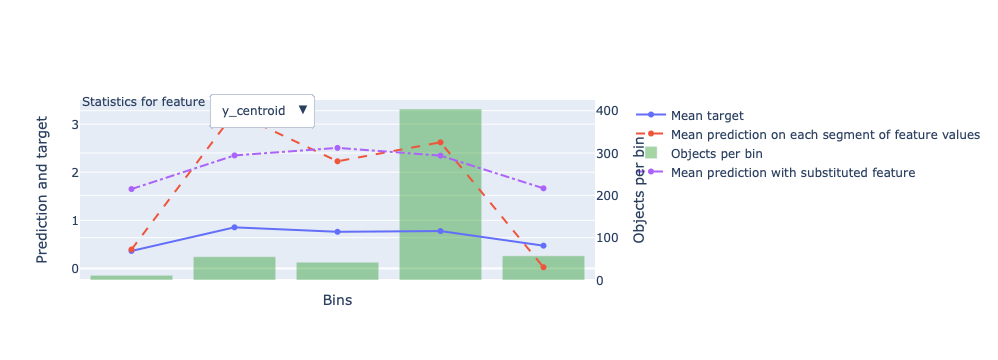

In [132]:
res = model.calc_feature_statistics(X_train,
                                    y_train,
                                    feature=[1, 2, 3, 4],
                                    plot=True)


## model predict probabilities (the entire dataset)

In [120]:
probs = model.predict_proba(X)


### feature importsnce

In [139]:
feature_import = model.get_feature_importance(prettified=True)


In [134]:
feature_import

,Feature Id,Importances
0,area_m,15.159030
1,range_elevation,12.044861
2,x_centroid,11.464264
3,mean_slope,8.814833
4,median_slope,7.448238
5,min_elevation,5.693697
6,y_centroid,5.384608
7,Rc,4.414305
8,max_slope,4.168981
9,rainy_days_frac,3.971328


### shap stuff

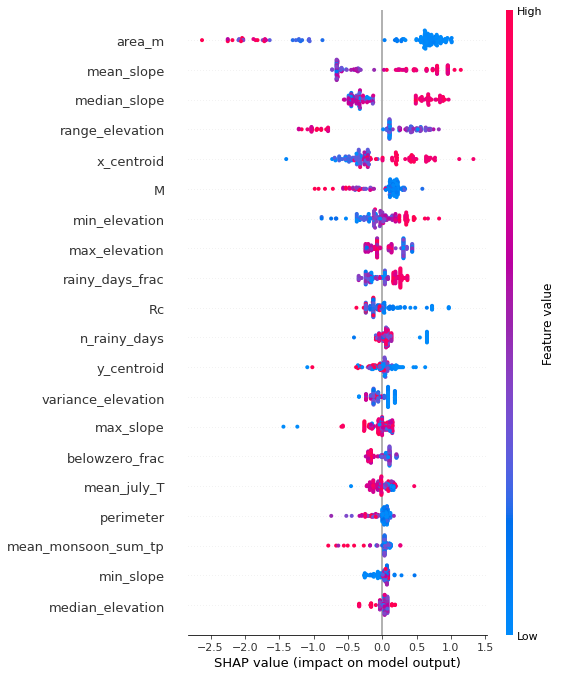

In [145]:
import shap 


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_validation)

shap.summary_plot(shap_values, X_validation)

### partial depend stuff
